# E-tivity 4: Comparison of Binary Classifiers

### Name: Pieter Johannes Alberts (Johann Alberts)
### Student ID: 22179046

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load and Inspect Data

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [3]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry coefficient    210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   type                     210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [5]:
# Check for missing values
df.isnull().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values in the dataset.

## Quick EDA

In [6]:
df.describe()

area   perimeter  compactness  length of kernel  width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       asymmetry coefficient  length of kernel groove        type  
count             210.000000               210.000000  210.000000  
mean                3.700201                 5.408071    2.000000  
std                 1.503557                 0.491480    0.818448  
min                 0.765100                 4.519000    1.000000  
25%                 2.561500                 5.045000    1.000000  
50%                 3.599000                 5.223000    2.000000  
75%                 4.768750                 5.877000    3.000000  
max                 8.456000                 6.550000    3.000000

In [7]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

There is an even split of seed types.

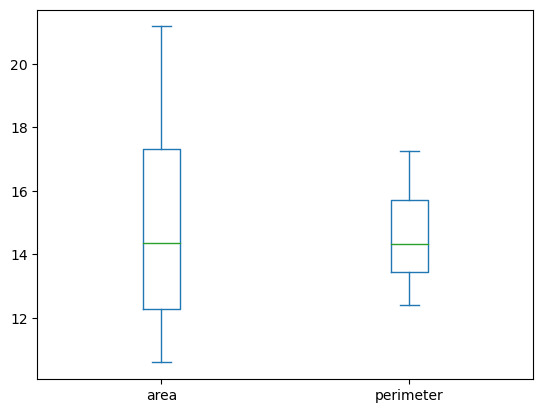

In [8]:
df[['area', 'perimeter']].plot(kind='box');

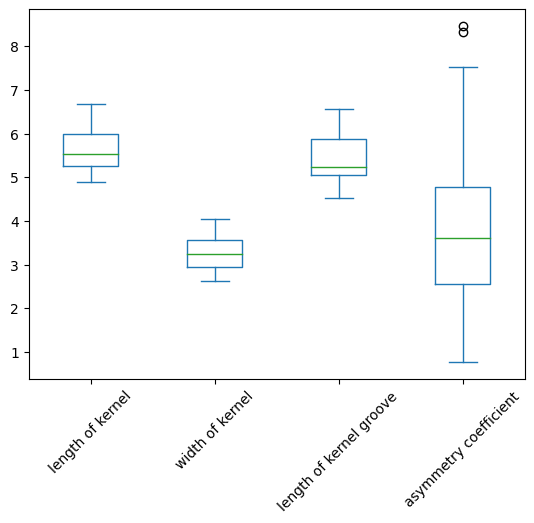

In [9]:
df[['length of kernel', 'width of kernel', 'length of kernel groove', 'asymmetry coefficient']].plot(kind='box')
plt.xticks(rotation=45);

The attribute `assymetry coefficient` is the only predictor with outliers. As such, `RobustScaler` will be used to transform this column. All other predictors will be transformed using `StandardScaler`.

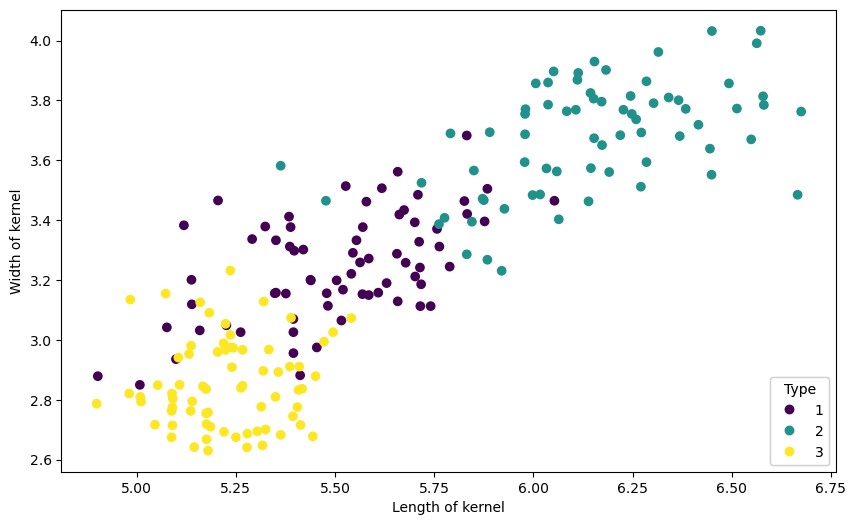

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
scatter = ax.scatter(df['length of kernel'], df['width of kernel'], c=df['type'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Type")
ax.add_artist(legend)
ax.set_xlabel('Length of kernel')
ax.set_ylabel('Width of kernel')
plt.show();

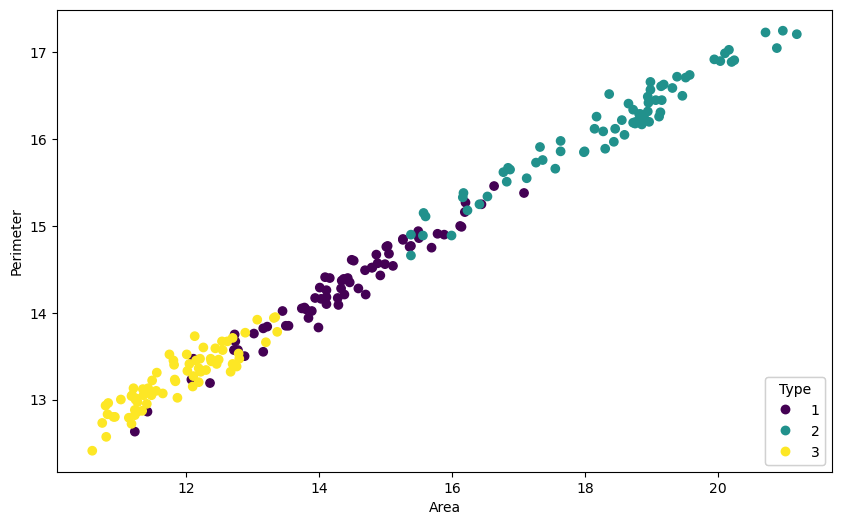

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
scatter = ax.scatter(df['area'], df['perimeter'], c=df['type'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Type")
ax.add_artist(legend)
ax.set_xlabel('Area')
ax.set_ylabel('Perimeter')
plt.show();

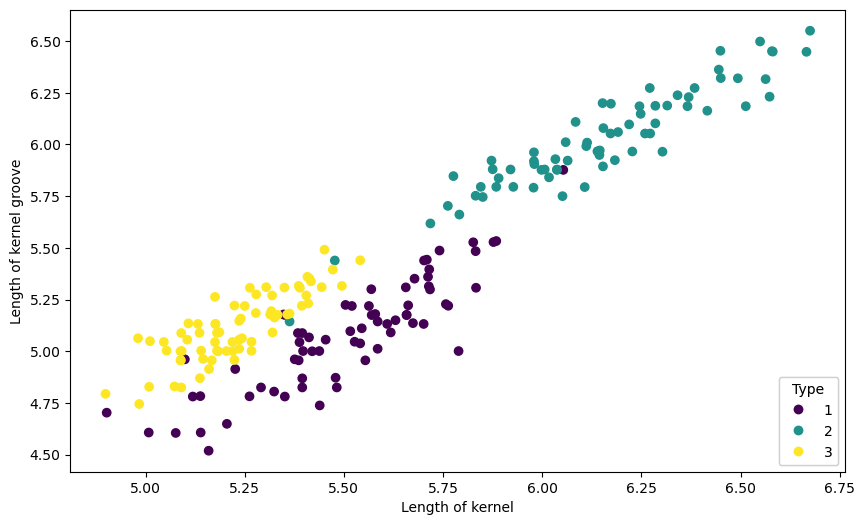

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
scatter = ax.scatter(df['length of kernel'], df['length of kernel groove'], c=df['type'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Type")
ax.add_artist(legend)
ax.set_xlabel('Length of kernel')
ax.set_ylabel('Length of kernel groove')
plt.show();

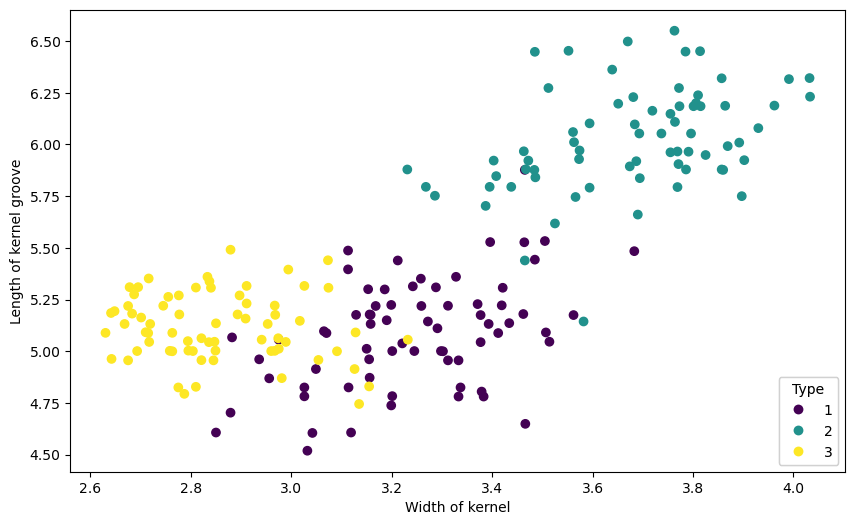

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
scatter = ax.scatter(df['width of kernel'], df['length of kernel groove'], c=df['type'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Type")
ax.add_artist(legend)
ax.set_xlabel('Width of kernel')
ax.set_ylabel('Length of kernel groove')
plt.show();

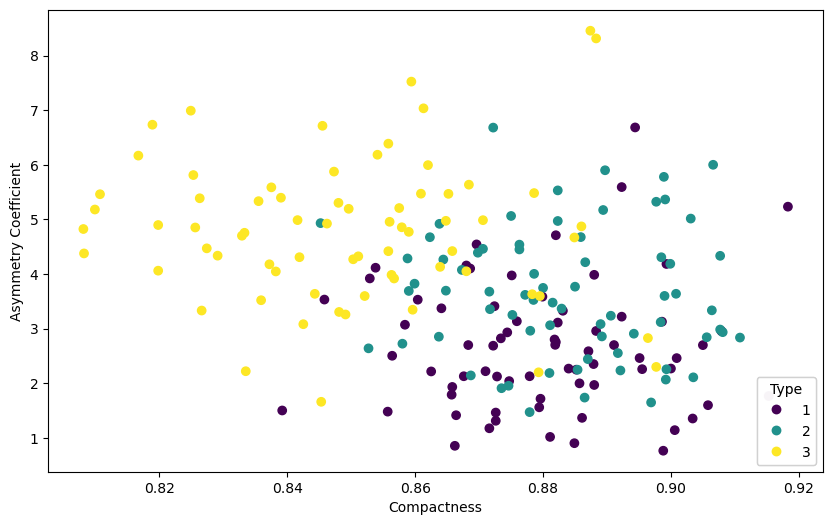

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
scatter = ax.scatter(df['compactness'], df['asymmetry coefficient'], c=df['type'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Type")
ax.add_artist(legend)
ax.set_xlabel('Compactness')
ax.set_ylabel('Asymmetry Coefficient')
plt.show();

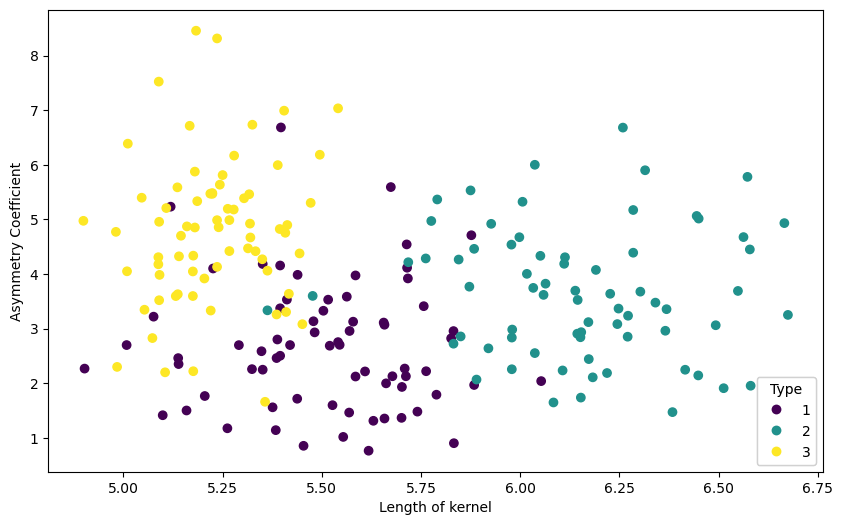

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
scatter = ax.scatter(df['length of kernel'], df['asymmetry coefficient'], c=df['type'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Type")
ax.add_artist(legend)
ax.set_xlabel('Length of kernel')
ax.set_ylabel('Asymmetry Coefficient')
plt.show();

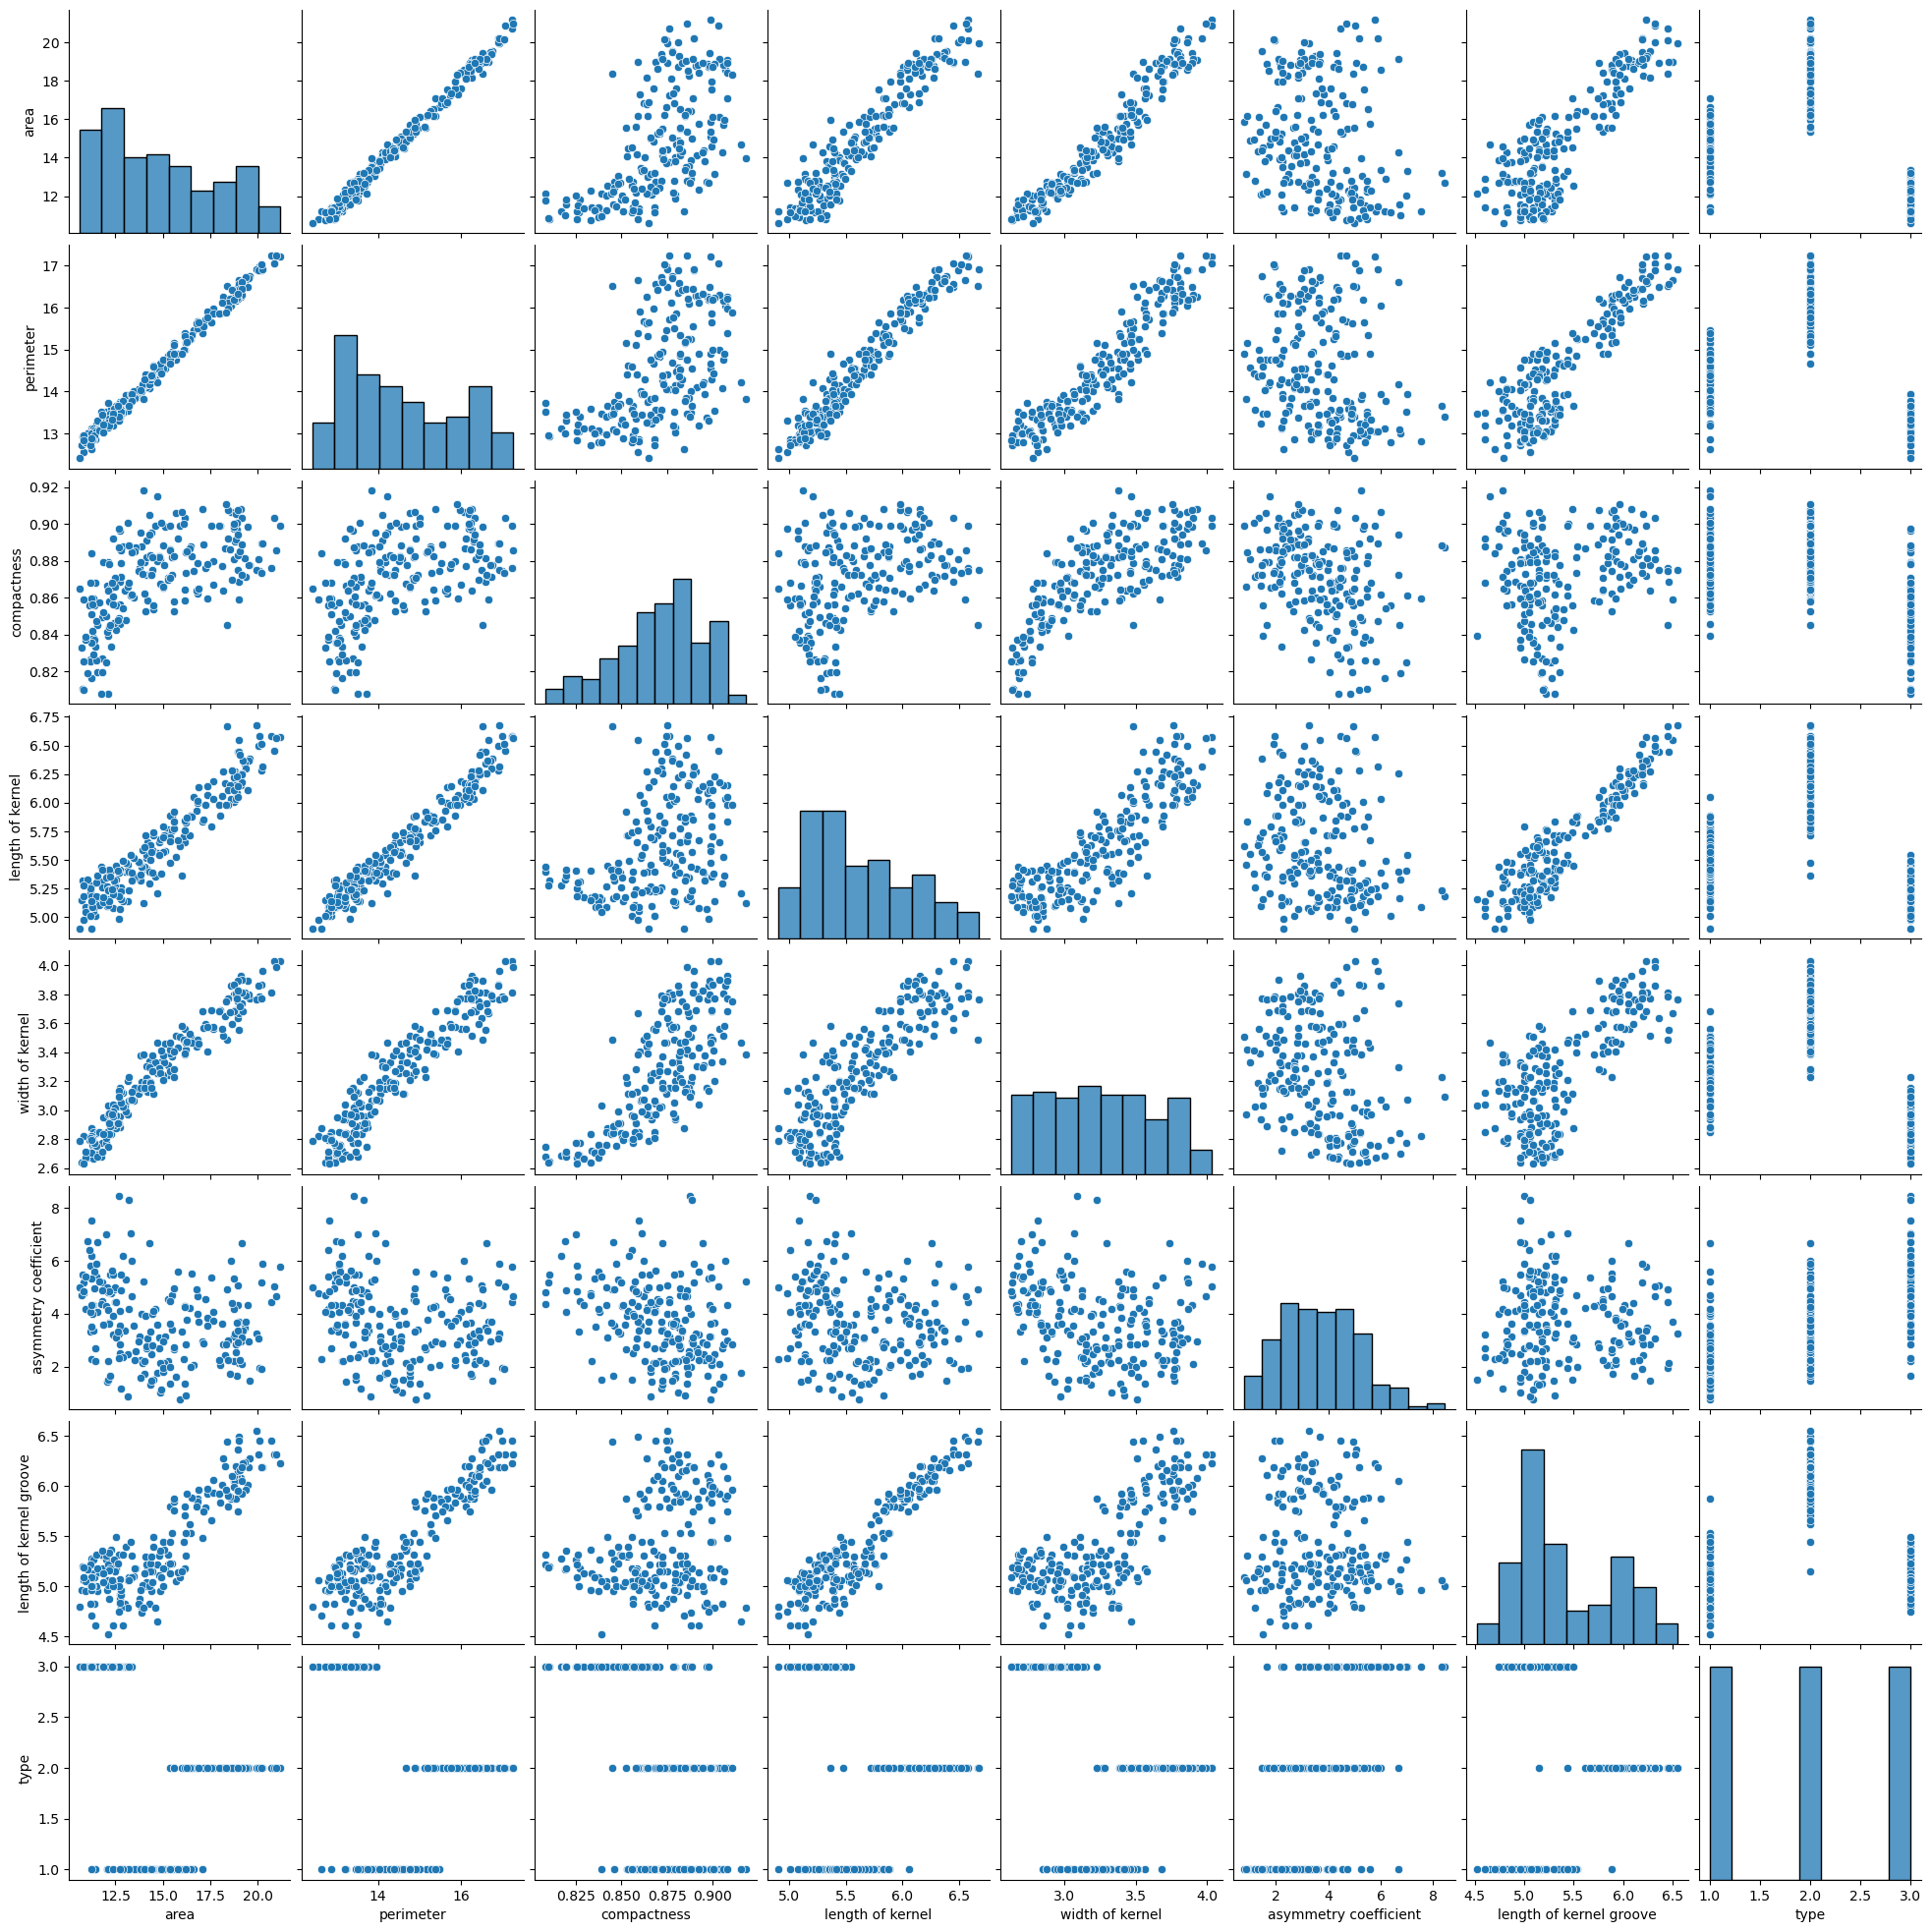

In [16]:
sns.pairplot(df)

Some of the scatter plots show a really nice separation between seed types, while others (e.g. Asymmetry Coefficients X Compactness) show that not attribute pairs result in a clean split.

## Task 2

Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. You will need to formulate a binary classification problem and transform the type column accordingly.

### 2.1 Binary Classification Problem Formulation

The `type` attribute has three possible values. Our requirements state that it needs to be transformed into a binary label. In order to achieve this, the following groupings can be performed:

- Type 1
- Type 2 and 3 (not type 1)

OR

- Type 2
- Type 1 and 3 (not type 2)

OR

- Type 3
- Type 1 and 2 (not type 3)

Since there's an equal number of examples for all three types, it doesn't appear that any particular split is better than another until further investigation may reveal more information. As such, the first option will be chosen (Type 1 and Not Type 1).

### 2.2 Data Preparation

In [17]:
# Create and use binary mapper for 'type' column
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

In [18]:
# store a list with the names of all predictors
cols_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
cols_outliers = ['asymmetry coefficient']
cols_no_outliers = list(set(cols_all) - set(cols_outliers))

In [19]:
# All columns
cols_all

['area',
 'perimeter',
 'compactness',
 'length of kernel',
 'width of kernel',
 'asymmetry coefficient',
 'length of kernel groove']

In [20]:
# Column(s) with outliers
cols_outliers

['asymmetry coefficient']

In [21]:
# Column(s) with no outliers
cols_no_outliers

['length of kernel',
 'area',
 'compactness',
 'width of kernel',
 'perimeter',
 'length of kernel groove']

In [22]:
# Estimator for pipeline to create dataframe
# and add column names to dataframe
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [23]:
# Estimator for pipeline to select columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [24]:
# Create proprocessing pipeline
# Adapted from example notebook, so
# log transform has been removed as it's
# not needed for the outlier column
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=cols_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=cols_outliers),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=cols_no_outliers),
            StandardScaler()
        ))
    ])
)

In [25]:
# Created features (X) and labels (y)
y = df['type']
X = df.drop('type', axis=1).values

# Split data into training and test sets
# Not that y is stratified becuase of imbalanced classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### 2.3 Grid Search for Best Parameters of Classifiers

In [26]:
# Track training times
timings = {}

In [27]:
# Adopted from an earlier module's notebook
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_errors = 1- train_scores
    test_errors = 1-test_scores
    
    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")

    
    plt.legend(loc="best")
    return plt

In [28]:
# Create a shuffle split with specified test size
# of 20%
cv = ShuffleSplit(n_splits=25, test_size=0.2)

In [29]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__class_weight': [None, 'balanced']}

search_svc = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=cv, refit=True)
search_svc.fit(X_train, y_train)
# record timing for classifier
timings['svm'] = search_svc.cv_results_['mean_fit_time'].sum()

print("Best CV score = %0.3f:" % search_svc.best_score_)
print("Best parameters: ", search_svc.best_params_)

# store the best params and best model for later use
SVM_best_params = search_svc.best_params_
SVM_best_model = search_svc.best_estimator_

Best CV score = 0.961:
Best parameters:  {'svm__C': 100, 'svm__class_weight': None, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [30]:
# View all the parameter keys of the SVC estimator
search_svc.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocess', 'estimator__svm', 'estimator__preprocess__memory', 'estimator__preprocess__steps', 'estimator__preprocess__verbose', 'estimator__preprocess__addcolumnnames', 'estimator__preprocess__featureunion', 'estimator__preprocess__addcolumnnames__columns', 'estimator__preprocess__featureunion__n_jobs', 'estimator__preprocess__featureunion__transformer_list', 'estimator__preprocess__featureunion__transformer_weights', 'estimator__preprocess__featureunion__verbose', 'estimator__preprocess__featureunion__outlier_columns', 'estimator__preprocess__featureunion__no_outlier_columns', 'estimator__preprocess__featureunion__outlier_columns__memory', 'estimator__preprocess__featureunion__outlier_columns__steps', 'estimator__preprocess__featureunion__outlier_columns__verbose', 'estimator__preprocess__featureunion__outlier_columns__columnselector', 'estimator__preprocess__featureunion__outl

In [31]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a parameter grid
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
}

search_rf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=cv, refit=True)
search_rf.fit(X_train, y_train)
# record timing for classifier
timings['rf'] = search_rf.cv_results_['mean_fit_time'].sum()

print("Best CV score = %0.3f:" % search_rf.best_score_)
print("Best parameters: ", search_rf.best_params_)

# store the best params and best model for later use
RF_best_params = search_rf.best_params_
RF_best_model = search_rf.best_estimator_

Best CV score = 0.915:
Best parameters:  {'rf__class_weight': None, 'rf__max_depth': 6, 'rf__n_estimators': 20}


### 2.4 Compare Classifiers on Test Set

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [32]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [33]:
# Taken from example notebook
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [34]:
# Store model metrics in variable for plotting and printing
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

In [35]:
print(f'SVM accuracy: {SVM_accuracy:.3f}')
print(f'SVM precision: {SVM_precision:.3f}')
print(f'SVM recall: {SVM_recall:.3f}')
print(f'SVM F1 score: {SVM_f1_score:.3f}')
print(f'SVM AUC score: {SVM_auc:.3f}')
print('')
print(f'RF accuracy: {RF_accuracy:.3f}')
print(f'RF precision: {RF_precision:.3f}')
print(f'RF recall: {RF_recall:.3f}')
print(f'RF F1 score: {RF_f1_score:.3f}')
print(f'RF AUC score: {RF_auc:.3f}')

SVM accuracy: 0.929
SVM precision: 0.867
SVM recall: 0.929
SVM F1 score: 0.897
SVM AUC score: 0.987

RF accuracy: 0.881
RF precision: 0.909
RF recall: 0.714
RF F1 score: 0.800
RF AUC score: 0.915


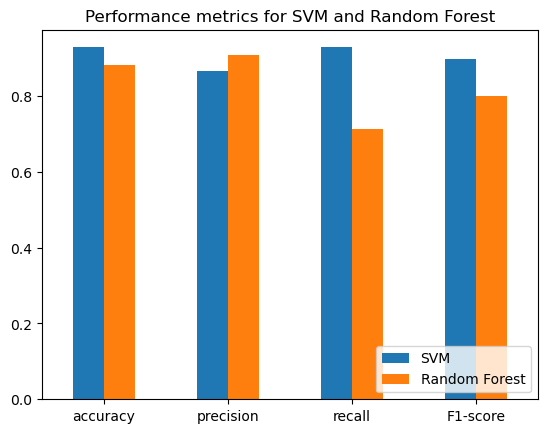

In [36]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc='lower right')
plt.title('Performance metrics for SVM and Random Forest')
plt.show()

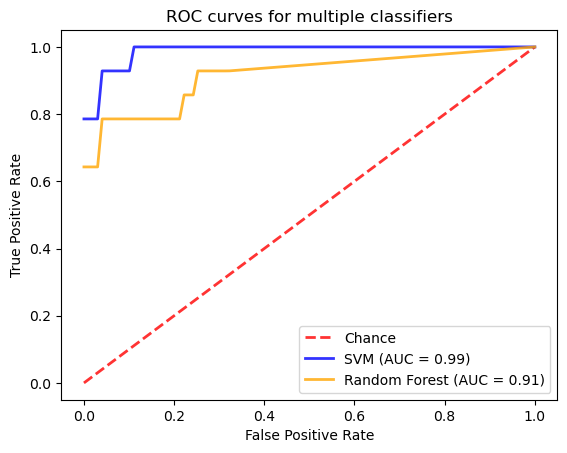

In [37]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

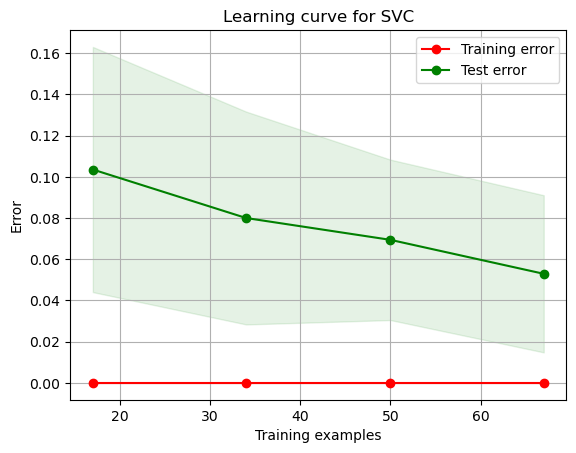

In [38]:
plot_learning_curve(SVM_best_model, "Learning curve for SVC", X_train, y_train, cv=cv, n_jobs=4, train_sizes = np.linspace(0.01, .5, 5));

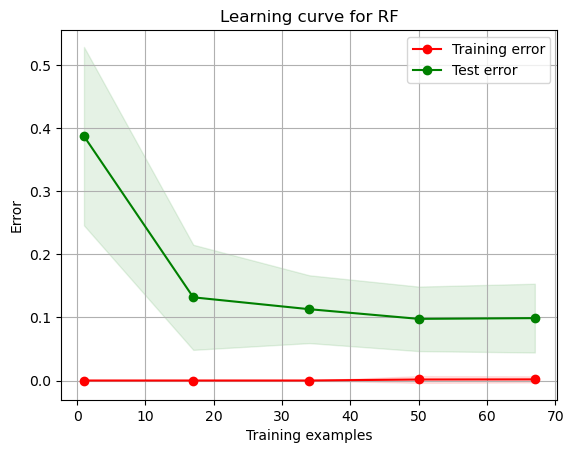

In [39]:
plot_learning_curve(RF_best_model, "Learning curve for RF", X_train, y_train, cv=cv, n_jobs=4, train_sizes = np.linspace(0.01, .5, 5));

### 2.5 Train the Final Model

In [40]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model_task_2 =pipe.fit(X, y)

In [41]:
filename = 'final_model_task_2.sav'
pickle.dump(final_model_task_2, open(filename, 'wb'))

### 2.6 Conclusion

Both SVC and Random Forest classifiers yielded good metrics on this unbalanced dataset. The dataset was balanced initially in terms of seed types (70 samples for each of the three types), but after conversion for binary classification, it was 70 for `type 1` and 140 for `not type 1`.

With no clear information from the dataset source showing whether there should be a high cost associated with False Positives or False Negatives (where Precision and Recall would be the best metrics respectively), the F1 score is chosen as the best metric for our imbalanced data.

Across three metrics (accuracy, recall, F1), SVC performed better than RF. The results are summarised below:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky">Estimator</th>
    <th class="tg-0pky">Accuracy</th>
    <th class="tg-0pky">Precision</th>
    <th class="tg-0pky">Recall</th>
    <th class="tg-0pky">F1</th>
    <th class="tg-0pky">AUC</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">SVC</td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.929</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.867</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.929</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.897</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.987</span></td>
  </tr>
  <tr>
    <td class="tg-0pky">Random Forest</td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.881</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.909</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.714</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.800</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.915</span></td>
  </tr>
</tbody>
</table>

Based on these metrics alone, the SVM Classifier is chosen here as the best estimator because of better scores for three metrics, including the F1 score in which we're most interested for unbalanced labels. It's worth mentioning that the RF Classifier scores slightly better with its `precision` score, though the difference here is negligible.

The training curves show that the RF Classifier converges more quickly than SVM, though the test error for the former is slightly higher than for the SVM Classifier. The SVM is still chosen as best as the learning curve for test data seems to be decreasing while that's not the case for RF.

## Task 3

Train a third classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest

The following two additional classifiers were selected for testing:

- MLPClassifier
- KNeighborsClassifier

In [42]:
# Ignore Convergence Warning
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 3.1 MLPClassifier

In [ ]:
# create the pipeline
pipe_mlpc = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlpc', MLPClassifier())])

# prepare a prameter grid
params_mlpc = {
    'mlpc__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'mlpc__solver': ['sgd', 'adam', 'lbfgs'],
    'mlpc__hidden_layer_sizes': [ (150,), (100,), (50,), (150, 150), (100, 100), (50, 50), (150, 100), (150, 50), (100, 50)],
    'mlpc__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlpc__activation': ['identity', 'tanh', 'relu']
}

search_mlpc = GridSearchCV(pipe_mlpc, params_mlpc, n_jobs=-1, cv=cv, refit=True)
search_mlpc.fit(X, y)
# record model timing
timings['mlpc'] = search_mlpc.cv_results_['mean_fit_time'].sum()

print("Best CV score = %0.3f:" % search_mlpc.best_score_)
print("Best parameters: ", search_mlpc.best_params_)

# store the best params and best model for later use
MLPC_best_params = search_mlpc.best_params_
MLPC_best_model = search_mlpc.best_estimator_

In [44]:
# Display mlpc best score as model output
# in previous cell was silenced due to
# ConvergenceWarnings
search_mlpc.best_score_

0.9619047619047619

In [45]:
# Display mlpc best parameters as model output
# in previous cell was silenced due to
# ConvergenceWarnings
MLPC_best_params

{'mlpc__activation': 'tanh',
 'mlpc__alpha': 0.001,
 'mlpc__hidden_layer_sizes': (150, 100),
 'mlpc__learning_rate': 'constant',
 'mlpc__solver': 'lbfgs'}

In [46]:
# Store MLPC metrics in variables for plotting and printing
MLPC_accuracy, MLPC_precision, MLPC_recall, MLPC_f1_score, MLPC_tpr, MLPC_auc = evaluate_model(X, y, MLPC_best_model)

In [47]:
print(f'MLPC accuracy: {MLPC_accuracy}')
print(f'MLPC precision: {MLPC_precision}')
print(f'MLPC recall: {MLPC_recall}')
print(f'MLPC f1 score: {MLPC_f1_score}')
print(f'MLPC AUC: {MLPC_auc}')

MLPC accuracy: 1.0
MLPC precision: 1.0
MLPC recall: 1.0
MLPC f1 score: 1.0
MLPC AUC: 1.0


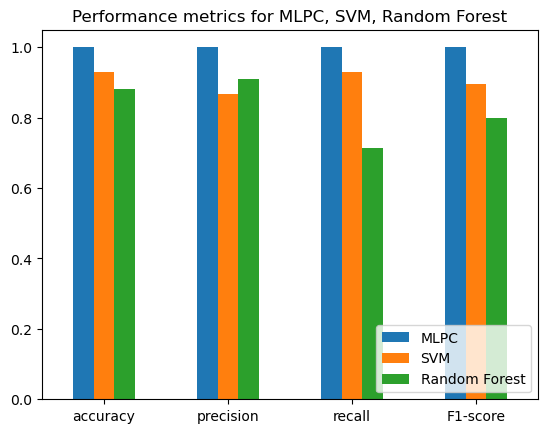

In [48]:
MLPC_metrics = np.array([MLPC_accuracy, MLPC_precision, MLPC_recall, MLPC_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'MLPC': MLPC_metrics, 'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc='lower right')
plt.title('Performance metrics for MLPC, SVM, Random Forest')
plt.show();

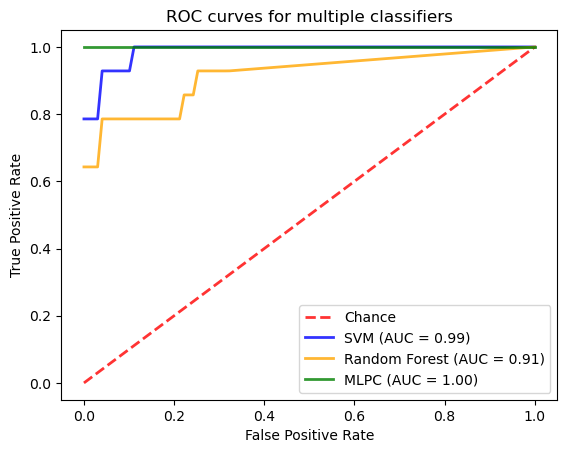

In [49]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLPC_tpr[0,:], lw=2, color='green', label='MLPC (AUC = %0.2f)' % (MLPC_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show();

### 3.2 KNeighborsClassifier

In [50]:
# create the pipeline
pipe_knn = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
params_knn = {
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 15, 20, 25, 30, 35, 40, 45, 50]
}

search_knn = GridSearchCV(pipe_knn, params_knn, n_jobs=-1, cv=cv, refit=True)
search_knn.fit(X, y)

# record model timing
timings['knn'] = search_knn.cv_results_['mean_fit_time'].sum()

print("Best CV score = %0.3f:" % search_knn.best_score_)
print("Best parameters: ", search_knn.best_params_)

# store the best params and best model for later use
KNN_best_params = search_knn.best_params_
KNN_best_model = search_knn.best_estimator_

Best CV score = 0.939:
Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 6, 'knn__weights': 'distance'}


In [51]:
# Store KNN metrics invariables for plotting and printing
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X, y, KNN_best_model)

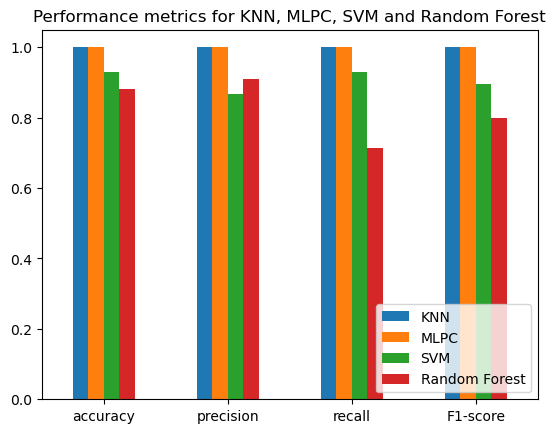

In [52]:
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'KNN': KNN_metrics, 'MLPC': MLPC_metrics, 'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc='lower right')
plt.title('Performance metrics for KNN, MLPC, SVM and Random Forest')
plt.show()

In [53]:
print(f'MLPC accuracy: {MLPC_accuracy:.3f}')
print(f'MLPC precision: {MLPC_precision:.3f}')
print(f'MLPC recall: {MLPC_recall:.3f}')
print(f'MLPC f1 score: {MLPC_f1_score:.3f}')
print(f'MLPC AUC: {MLPC_auc:.3f}')
print('')
print(f'KNN accuracy: {KNN_accuracy:.3f}')
print(f'KNN precision: {KNN_precision:.3f}')
print(f'KNN recall: {KNN_recall:.3f}')
print(f'KNN f1 score: {KNN_f1_score:.3f}')
print(f'KNN AUC: {KNN_auc:.3f}')

MLPC accuracy: 1.000
MLPC precision: 1.000
MLPC recall: 1.000
MLPC f1 score: 1.000
MLPC AUC: 1.000

KNN accuracy: 1.000
KNN precision: 1.000
KNN recall: 1.000
KNN f1 score: 1.000
KNN AUC: 1.000


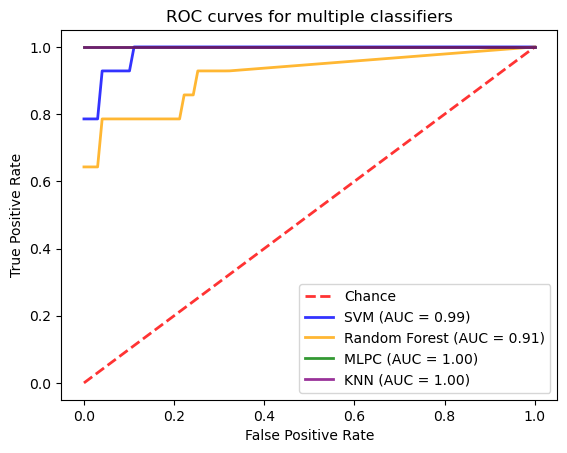

In [54]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLPC_tpr[0,:], lw=2, color='green', label='MLPC (AUC = %0.2f)' % (MLPC_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='purple', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show();

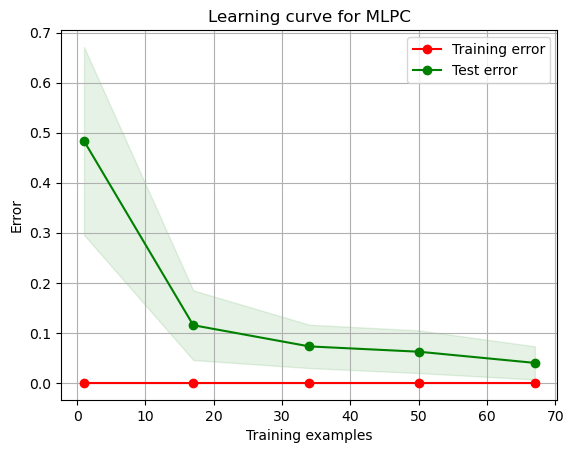

In [55]:
plot_learning_curve(MLPC_best_model, "Learning curve for MLPC", X_train, y_train, cv=cv, n_jobs=1, train_sizes = np.linspace(0.01, .5, 5));

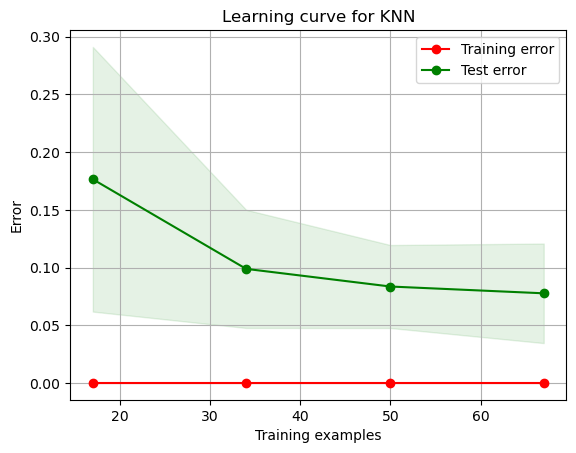

In [56]:
plot_learning_curve(KNN_best_model, "Learning curve for KNN", X_train, y_train, cv=cv, n_jobs=1, train_sizes = np.linspace(0.01, .5, 5));

### 3.3 Training times

Text(0.5, 0, 'seconds')

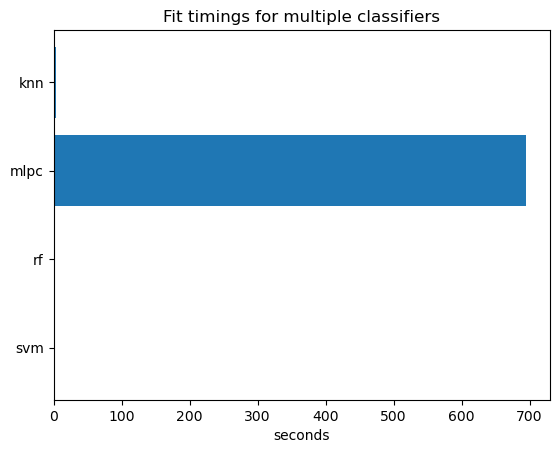

In [57]:
plt.barh(list(timings.keys()), list(timings.values()))
plt.title('Fit timings for multiple classifiers')
plt.xlabel('seconds')

Text(0.5, 0, 'seconds')

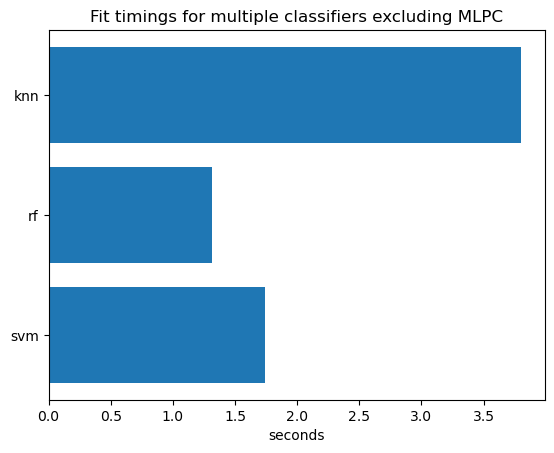

In [60]:
del timings['mlpc']
plt.barh(list(timings.keys()), list(timings.values()))
plt.title('Fit timings for multiple classifiers excluding MLPC')
plt.xlabel('seconds')

### 3.4 Summary

Both the MLPClassifier and KNeighnorsClassifier achieved the highest metrics in accuracy, precision, recall, F1 score and AUC. The metrics for all four classifiers are presented below:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky">Estimator</th>
    <th class="tg-0pky">Accuracy</th>
    <th class="tg-0pky">Precision</th>
    <th class="tg-0pky">Recall</th>
    <th class="tg-0pky">F1</th>
    <th class="tg-0pky">AUC</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">SVC</td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.929</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.867</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.929</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.897</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.987</span></td>
  </tr>
  <tr>
    <td class="tg-0pky">Random Forest</td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.881</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.909</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.714</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.800</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal">0.915</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">MLPC</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">KNN</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">1.000</span></td>
  </tr>
</tbody>
</table>

Looking at the timing plot, we can see that the MLPClassifier took far longer to train than any of the other models which were tested. From a computational efficiency perspective, on this dataset and binary classification problem as defined, I may choose to use KNN instead as it achieved the same performance metrics and seems much cheaper to train.

Both MLPC and KNN show better convergence in the learning curves as more samples are utilised. The training and test errors are roughly the same at the far right of the learning curves. Interestingly, the training error for learning curves doesn't increase with more samples (apart from RF which appears to increase slightly on the very far right of the plot) which I found surprising. I would usually suggest that that indicates possible overfitting, though the performance of both models on test data - and hence unseen data - indicate that generalisation should not be a problem. The few attributes of the dataset and the simple binary classification problem may explain why all models managed to be optmised so effectively on the training data.

## Reflection

This was a really intersting e-tivity which seemed too easy at first, but realising that there were other avenues to explore (like plotting learning curves) made it more challenging.

**What I saw my peers inplement and wish I had:**

- Using clustering to formulate a binary classification problem

**What was changed following peer feedback**

- I used the `cv` variable as created using ShuffleSplit in both my learning curves and GridSearchCV instead of using it only in my learning curves after my oversight was pointed out to me
- I removed my timing class as a peer pointed out that timing information is stored as an attribute once a model has been optimesed

**What I implemented from peer's work**

- Using a pairplot as my scatterplots were really good with colours and labels but a pairplot gives a better oversight of correlation

